In [ ]:
# https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset/data?select=Dataset_BUSI_with_GT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/busidataset.zip > /dev/null

In [ ]:
!pip3 install torchsummary

In [ ]:
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.init as init
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")

np.random.seed(42)
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# **Data preparation**

In [ ]:
def get_unique_pixel_values(image, image_type='gray'):
    """
    Function returns the unique pixel values of the image.

    Args:
        image: Input image.

    Returns:
        Array containing unique pixel values.
    """
    img_size = (224, 224)

    unique_values = []
    if image_type=='rgb':
        for channel in image:
            for row in channel:
                for pixel in row:
                    if pixel not in unique_values:
                        unique_values.append(pixel)
    else:
        for row in image:
            for pixel in row:
                if pixel not in unique_values:
                    unique_values.append(pixel)

    return unique_values

In [ ]:
mask = cv2.imread('/content/Dataset_BUSI_with_GT/benign/benign (2)_mask.png', 0)
data = cv2.imread('/content/Dataset_BUSI_with_GT/benign/benign (2).png', 1)
get_unique_pixel_values(mask)

[0, 255]

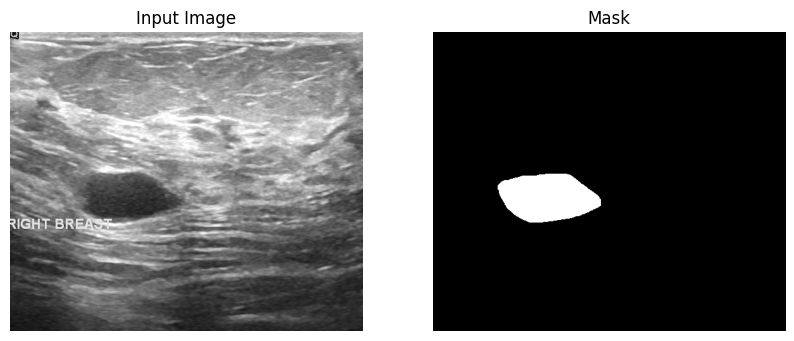

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("Input Image")
plt.imshow(data)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("Mask")
plt.imshow(mask, cmap='gray')

plt.show()

In [ ]:
mask = cv2.imread('/content/Dataset_BUSI_with_GT/normal/normal (1)_mask.png', 0)
get_unique_pixel_values(mask)

[0]

In [ ]:
root_dir = '/content/Dataset_BUSI_with_GT'

In [ ]:
class BusiDataset(Dataset):
    def __init__(self, root_dir, img_transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.data = []
        for label in os.listdir(root_dir):
            masks = glob.glob(root_dir + f"/{label}/*_mask.png")
            for mask in masks:
                self.data.append((mask.replace('_mask.png', '.png'), mask))

        self.image_transform = img_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = Image.open(self.data[index][0]).convert('L')
        mask = Image.open(self.data[index][1]).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
            mask = self.image_transform(mask)

        return (image, mask)

In [ ]:
img_size = (224, 224)

img_transform = transforms.Compose([
              transforms.Resize(img_size),
              transforms.ToTensor(),
])

data = BusiDataset(root_dir=root_dir, img_transform=img_transform)

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
len(train_set), len(test_set)

(624, 156)

In [ ]:
train_set[0][1].min(), train_set[0][1].max()

(tensor(0.), tensor(1.))

In [ ]:
batch_size = 16
train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
test_loader = DataLoader(test_set,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=2)

In [ ]:
for batch in train_loader:
    # Assuming your dataset returns a tuple (inputs, targets)
    inputs, targets = batch

    # Print the shapes
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: torch.Size([16, 1, 224, 224])
Target shape: torch.Size([16, 1, 224, 224])


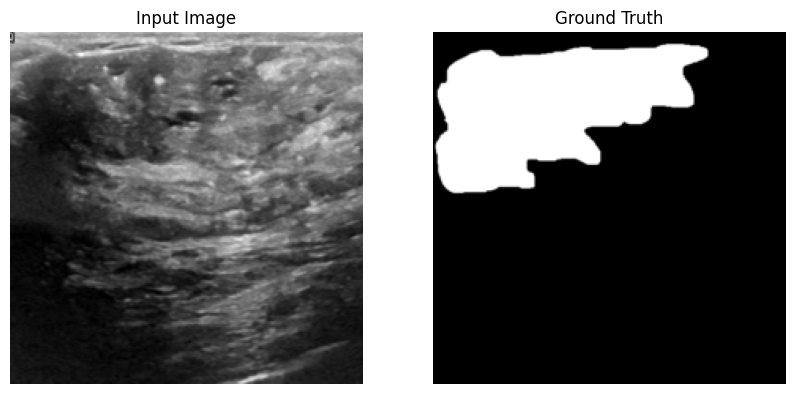

In [ ]:
index = 0
idx_to_cls = {0: "benign", 1: "malignant", 2: "normal"}

test_image = train_set[index][0].numpy().transpose(1,2,0)
test_image = np.clip(test_image, 0, 1)
test_mask = train_set[index][1].numpy().transpose(1,2,0)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("Input Image")
plt.imshow(test_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("Ground Truth")
plt.imshow(test_mask, cmap='gray')

plt.show()

# **Model**

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(ConvBlock, self).__init__()
        self.conv2d_1 = nn.Conv2d(input_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_1 = nn.BatchNorm2d(out_channel)
        self.relu_1 = nn.ReLU()

        self.dropout = nn.Dropout(dropout)

        self.conv2d_2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_2 = nn.BatchNorm2d(out_channel)
        self.relu_2 = nn.ReLU()

    def forward(self, x):
        x = self.conv2d_1(x)
        x = self.batchnorm_1(x)
        x = self.relu_1(x)

        x = self.dropout(x)

        x = self.conv2d_2(x)
        x = self.batchnorm_2(x)
        x = self.relu_2(x)

        return x

# Down-Sample
class Encoder(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(Encoder, self).__init__()
        self.conv2d_1 = ConvBlock(input_channel, out_channel, dropout)
        self.maxpool = nn.MaxPool2d((2,2))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv2d_1(x)
        p = self.maxpool(x)
        p = self.dropout(p)

        return x, p

# Up-Sample
class Decoder(nn.Module):
    def __init__(self, input_channel, output_channel, dropout):
        super(Decoder, self).__init__()
        self.conv_t = nn.ConvTranspose2d(input_channel, output_channel, stride=2, kernel_size=2)
        self.conv2d_1 = ConvBlock(output_channel*2, output_channel, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, skip):
        x = self.conv_t(x)
        x = torch.cat([x, skip], dim=1)
        x = self.dropout(x)
        x = self.conv2d_1(x)

        return x

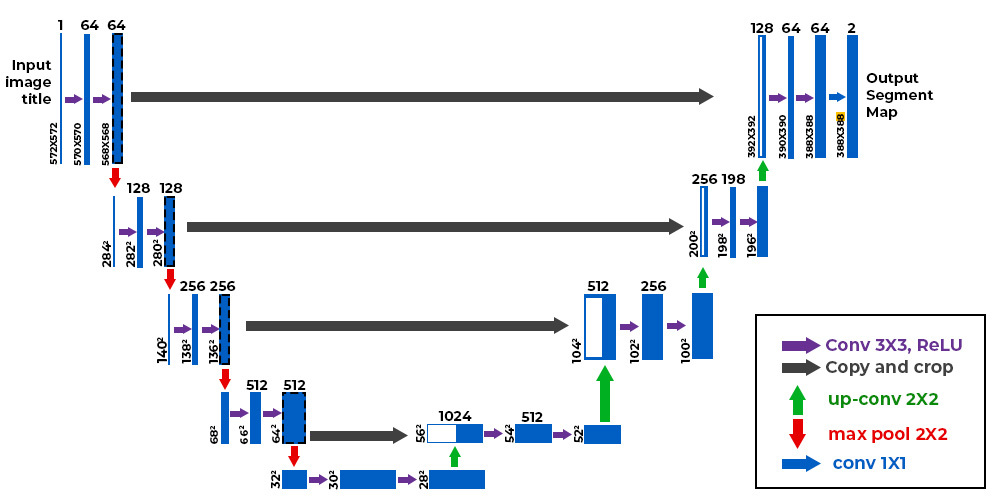

In [ ]:
class Unet(nn.Module):
    def __init__(self, input_channel=1, dropout=0.1):
        super().__init__()
        self.encoder_1 = Encoder(input_channel, 64, dropout)
        self.encoder_2 = Encoder(64, 128, dropout)
        self.encoder_3 = Encoder(128, 256, dropout)
        self.encoder_4 = Encoder(256, 512, dropout)

        self.conv_block = ConvBlock(512, 1024, dropout)

        self.decoder_1 = Decoder(1024, 512, dropout)
        self.decoder_2 = Decoder(512, 256, dropout)
        self.decoder_3 = Decoder(256, 128, dropout)
        self.decoder_4 = Decoder(128, 64, dropout)

        self.cls = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.relu = nn.Sigmoid()

    def forward(self, x):

        """ ------ Encoder ------"""
        x1, p1 = self.encoder_1(x)
        x2, p2 = self.encoder_2(p1)
        x3, p3 = self.encoder_3(p2)
        x4, p4 = self.encoder_4(p3)

        """ ------ BottleNeck ------"""
        x5 = self.conv_block(p4)

        """ ------ Decoder ------"""
        x6 = self.decoder_1(x5, x4)
        x7 = self.decoder_2(x6, x3)
        x8 = self.decoder_3(x7, x2)
        x9 = self.decoder_4(x8, x1)

        """ ------ Final Layer ------"""
        x_final = self.cls(x9)
        x_final = self.relu(x_final)

        return x_final

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)

In [ ]:
random_input = torch.randn(2, 1, 224, 224)

model = Unet(input_channel=1, dropout=0.1)
data = model(random_input)
data.shape

torch.Size([2, 1, 224, 224])

In [ ]:
from torchsummary import summary

model = Unet(input_channel=1, dropout=0.1).to(device)
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
           Dropout-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]          36,928
       BatchNorm2d-6         [-1, 64, 224, 224]             128
              ReLU-7         [-1, 64, 224, 224]               0
         ConvBlock-8         [-1, 64, 224, 224]               0
         MaxPool2d-9         [-1, 64, 112, 112]               0
          Dropout-10         [-1, 64, 112, 112]               0
          Encoder-11  [[-1, 64, 224, 224], [-1, 64, 112, 112]]               0
           Conv2d-12        [-1, 128, 112, 112]          73,856
      BatchNorm2d-13        [-1, 128, 112, 112]             256
             ReLU-14    

# **Utils**

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, criterion, device, display_sample):
        self.current_epoch = 0
        self.optimizer = optimizer
        self.criterion = criterion
        self.model = model
        self.device = device
        self.display_sample = display_sample
        self.log_interval = 15

        # Lists to store training and validation metrics
        self.train_losses = []
        self.val_losses = []
        self.train_dices = []
        self.val_dices = []

        # Best model and its metrics
        self.best_model = None
        self.best_dice = 0.0
        self.best_epoch = 0

    def dice_coeff(self, predicted, target, smooth=1e-5):
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target)
        dice = (2. * intersection + smooth) / (union + smooth)
        return dice

    def save_best_model(self, epoch, dice):
        if dice > self.best_dice:
            self.best_dice = dice
            self.best_epoch = epoch
            self.best_model = self.model.state_dict()

            filename = f'best_model_epoch{epoch}_dice{dice:.4f}.pth'
            torch.save(self.best_model, filename)

    def to_numpy(self, tensor):
        # Move tensor to CPU and convert to NumPy array
        return tensor.cpu().detach().numpy()

    def threshold_prediction(self, predicted):
        # Threshold predicted values
        predicted[predicted < 0.5] = 0
        predicted[predicted >= 0.5] = 1
        return predicted

    @torch.inference_mode()
    def display_prediction(self, display_sample):
        model.eval()
        image = display_sample[0]
        mask = display_sample[1]
        pred = self.model(image.to(device).unsqueeze(0)).squeeze()

        # Convert tensors to NumPy arrays
        image_np, mask_np, predicted_np = map(self.to_numpy, (image, mask, pred))

        # Threshold the predicted values
        predicted_np_thresholded = self.threshold_prediction(predicted_np)

        fig, axes = plt.subplots(1, 3, figsize=(10, 5))
        titles = ['Image', 'Mask', 'Predicted']
        for ax, data, title in zip(axes, [image, mask, predicted_np, predicted_np_thresholded], titles):
            ax.imshow(data.squeeze(), cmap='gray' if 'Mask' in title else 'gray')
            ax.set_title(title)
            ax.axis('off')

        plt.show()

    def train(self, train_loader, val_loader, num_epochs=1):
        max_epochs = self.current_epoch + num_epochs
        for epoch in range(num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            train_dice = 0.0
            val_dice = 0.0

            # Training loop
            for images, masks in train_loader:
                images, masks = images.to(self.device), masks.to(self.device)

                self.model.train()
                self.optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                dice = self.dice_coeff(outputs, masks)

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_dice += dice

            # Validation loop
            self.model.eval()
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(self.device), masks.to(self.device)
                    outputs = self.model(images)
                    val_loss += self.criterion(outputs, masks).item()
                    val_dice += self.dice_coeff(outputs, masks)

            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            avg_train_dice = train_dice / len(train_loader)
            avg_val_dice = val_dice / len(val_loader)

            # Display
            print('='*45 + f"Epoch [{self.current_epoch + 1}/{max_epochs}]" + '='*45)
            print(f"Training loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f} | Val Loss: {avg_val_loss:.4f},  Val Dice: {avg_val_dice:.4f}")
            self.current_epoch += 1
            self.display_prediction(self.display_sample)

            # Save metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_dices.append(avg_train_dice)
            self.val_dices.append(avg_val_dice)

            # Save best model
            # self.save_best_model(epoch + 1, avg_val_dice)

    def get_metrics(self):
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_dices': self.train_dices,
            'val_dices': self.val_dices,
            'best_model': self.best_model,
            'best_dice': self.best_dice,
            'best_epoch': self.best_epoch
        }

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().numpy()

def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted

def plot_subplots(image, mask, predicted, threshold=0.5):
    # Convert tensors to NumPy arrays
    image_np, mask_np, predicted_np = map(to_numpy, (image, mask, predicted))

    # Threshold the predicted values
    predicted_np_thresholded = threshold_prediction(predicted_np, threshold)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Adjust figsize as needed

    # Plot Image, Mask, Predicted, and Thresholded Predicted
    titles = ['Image', 'Mask', 'Predicted']
    for ax, data, title in zip(axes, [image_np, mask_np, predicted_np, predicted_np_thresholded], titles):
        ax.imshow(data.squeeze(), cmap='gray' if 'Mask' in title else 'gray')
        ax.set_title(title)
        ax.axis('off')

    plt.show()

In [ ]:
def dice_coef_loss(inputs, target):
    smooth = 1e-6
    intersection = 2.0 * (target*inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection/union)

def BCE_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    BCE_loss = nn.BCELoss()
    BCE_score = BCE_loss(inputs, target)

    return BCE_score + dice_score

# **Train**

In [ ]:
model = Unet(1).to(device)
learning_rate = 0.0001
weight_decay = 1e-6

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

trainer = Trainer(model=model, optimizer=optimizer, criterion=BCE_dice_loss, device=device, display_sample=train_set[8])

In [ ]:
trainer.train(train_loader, test_loader, 100)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
torch.save(model.state_dict(), 'best.pt')
!cp /content/best.pt /content/drive/MyDrive

In [ ]:
contents = torch.load("/content/drive/MyDrive/best.pt")
print(type(contents))  # Check if it's a state dictionary or a model object

<class '__main__.Unet'>


In [ ]:
model = Unet(1).to(device)
state_dict = torch.load("/content/drive/MyDrive/best.pt")
model.load_state_dict(state_dict)
learning_rate = 0.0001
weight_decay = 1e-6

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

trainer = Trainer(model=model, optimizer=optimizer, criterion=BCE_dice_loss, device=device, display_sample=train_set[8])

TypeError: Expected state_dict to be dict-like, got <class '__main__.Unet'>.

In [ ]:
trainer.train(train_loader, test_loader, 50)

# **Result**

In [ ]:
for sample in test_set[:20]:
    image = sample[0].to(device)
    mask = sample[1]
    pred = model(image.unsqueeze(0)).squeeze()
    plot_subplots(image, mask, pred)

Output hidden; open in https://colab.research.google.com to view.